In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
data=yf.Ticker("TSLA")
hist=data.history(period="3y")
hist.to_csv("TSLA.csv")

In [3]:
data=pd.read_csv("TSLA.csv")
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-04-09,54.330002,55.000000,53.922001,54.462002,29520000,0,0.0
1,2019-04-10,55.348000,55.675999,54.577999,55.212002,35306500,0,0.0
2,2019-04-11,53.660000,54.099998,53.119999,53.683998,49179500,0,0.0
3,2019-04-12,54.043999,54.389999,53.366001,53.540001,33730000,0,0.0
4,2019-04-15,53.726002,53.776001,51.726002,53.276001,50193000,0,0.0


In [4]:
data.shape

(758, 8)

In [5]:
data.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [6]:
#performing univariate time series analysis

uni_data=data[["Date","Close"]]
type(uni_data["Date"])

pandas.core.series.Series

In [7]:
uni_data["Date"]=pd.to_datetime(uni_data["Date"])

In [8]:
uni_data.set_index("Date",inplace=True)

In [9]:
uni_data.head()

,Close
Date,
2019-04-09,54.462002
2019-04-10,55.212002
2019-04-11,53.683998
2019-04-12,53.540001
2019-04-15,53.276001


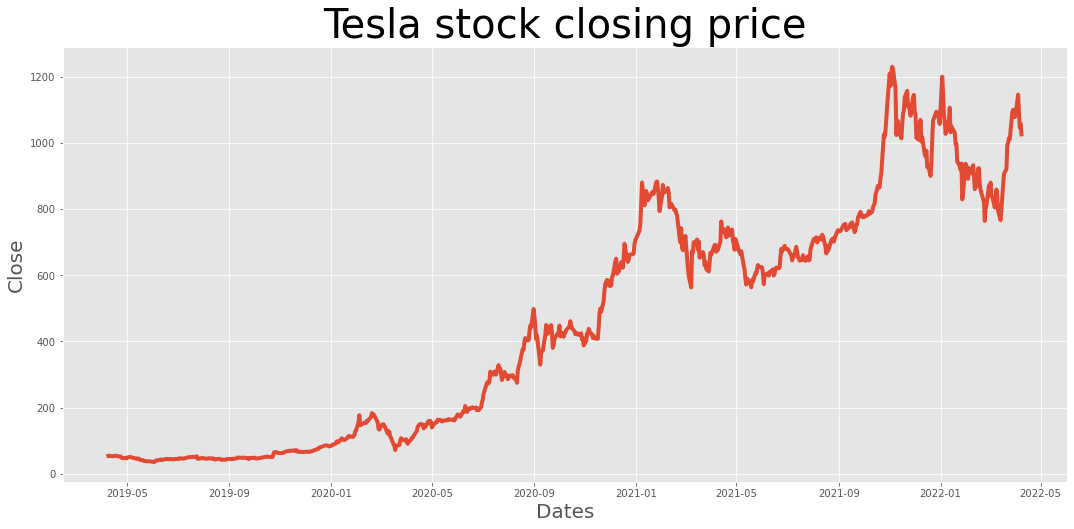

In [10]:
plt.style.use("ggplot")
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(uni_data["Close"],linewidth=4)
plt.xlabel("Dates",fontsize=20)
plt.ylabel("Close",fontsize=20)
plt.title("Tesla stock closing price",fontsize=40)
plt.show()

A probability distribution can also be used to illustrate the data in our series.

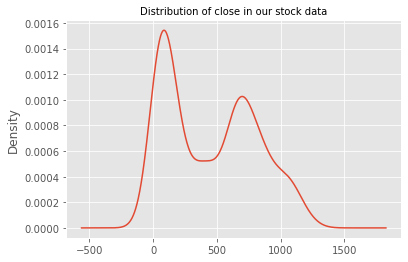

In [11]:
#distribution of our dataset
data_close=uni_data["Close"]
data_close.plot(kind="kde")
plt.title("Distribution of close in our stock data",fontsize=10)
plt.show()

A time series is also thought to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.
The components' definitions are as follows:

The level is the sum of all the values in a series.
The trend is the upward or downward movement of the series' value.
The series' short-term cycle is known as seasonality.
Noise is the term for the random variation in the series

#### check for stationarity of the data
Time series analysis only works with stationary data, so we must first determine whether a series is stationary. Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary.

What does it mean for data to be stationary?

The mean of the series should not be a function of time. Because the mean increases over time, the red graph below is not stationary.

## ADF(augmented dickey-fuller test)
the dickey fuller test is the most extensively used statistical tests.It can be used to establish whether a series has a unit root and as a result whether the series is stationary
There are mainly two null and alternate hypothesis
Null Hypothesis: The series has a unit root (a =1).
    Alternative Hypothesis: There is no unit root in the series.
        he series is considered to be non-stationary if the null hypothesis is not rejected. As a result, the series can be linear or difference stationary. If both the mean and standard deviation are flat lines, the series becomes stationary (constant mean and constant variance).

In [12]:
#Test for stationarity
def test_stationarity(time_Series):
    #datetime rolling statistic method
    rolling_mean=time_Series.rolling(12).mean()
    rolling_std=time_Series.rolling(12).std()
#     plot the statistice
    plt.figure(figsize=(18,8))
    plt.grid(True)
    plt.plot(time_Series,color="red",linewidth=3)
    plt.plot(rolling_mean,color="yellow",linewidth=3)
    plt.plot(rolling_std,color="blue",linewidth=3)
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    print("-"*60)
    print("Result of dickeyFuller test is")
    adft=adfuller(time_Series,autolag="AIC",  store=False,
    regresults=False)
    output=pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,value in adft[4].items():
        output["critical value (%s)"%key]=value
    print(output)

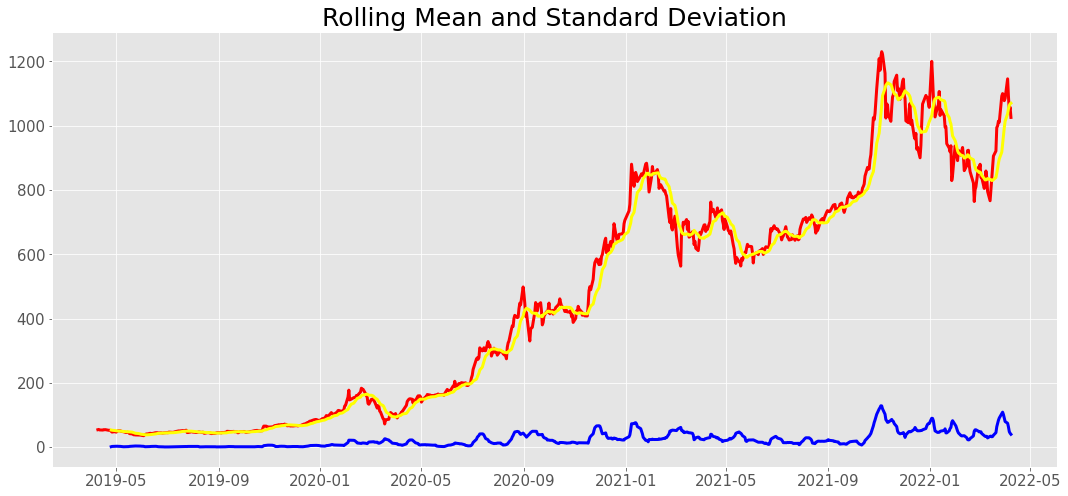

------------------------------------------------------------
Result of dickeyFuller test is
Test Statistics                 -0.492631
p-value                          0.893447
No. of lags used                 0.000000
Number of observations used    757.000000
critical value (1%)             -3.439018
critical value (5%)             -2.865366
critical value (10%)            -2.568807
dtype: float64


In [13]:
test_stationarity(data_close)

As show in the graph our data is not stationary so in order to do stationary we need to do differncing method whick will make our data stationary

In [14]:
diff_data=data_close.diff()
diff_data.isna().sum()
diff_data.dropna(inplace=True)

In [15]:
diff_data

Date
2019-04-10     0.750000
2019-04-11    -1.528004
2019-04-12    -0.143997
2019-04-15    -0.264000
2019-04-16     1.396000
                ...    
2022-04-04    60.859985
2022-04-05   -54.189941
2022-04-06   -45.500000
2022-04-07    11.500000
2022-04-08   -31.770020
Name: Close, Length: 757, dtype: float64

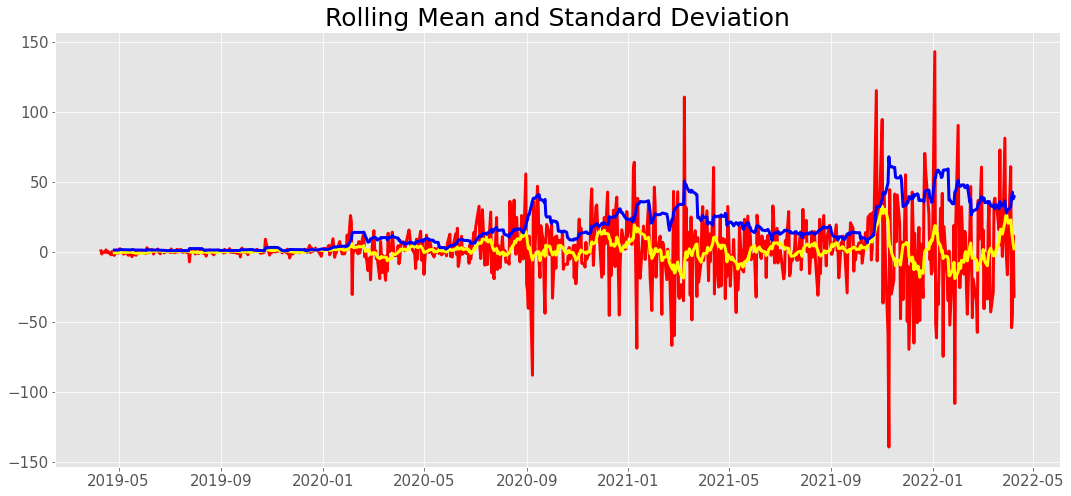

------------------------------------------------------------
Result of dickeyFuller test is
Test Statistics                -27.836092
p-value                          0.000000
No. of lags used                 0.000000
Number of observations used    756.000000
critical value (1%)             -3.439029
critical value (5%)             -2.865371
critical value (10%)            -2.568810
dtype: float64


In [16]:
test_stationarity(diff_data)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We can reject the null hypothesis. So, the time series is in fact stationary.

**Decompose the time series :**
To start with, we want to decompose the data to seperate the seasonality, trend and residual. Since we have 3 years of stock data. We would expect there's a yearly or weekly pattern. Let's use a function seasonal_decompose in statsmodels to help us find it.

In [17]:
decompose_TS_data=seasonal_decompose(data["Close"],model="multiplicative",freq=30)

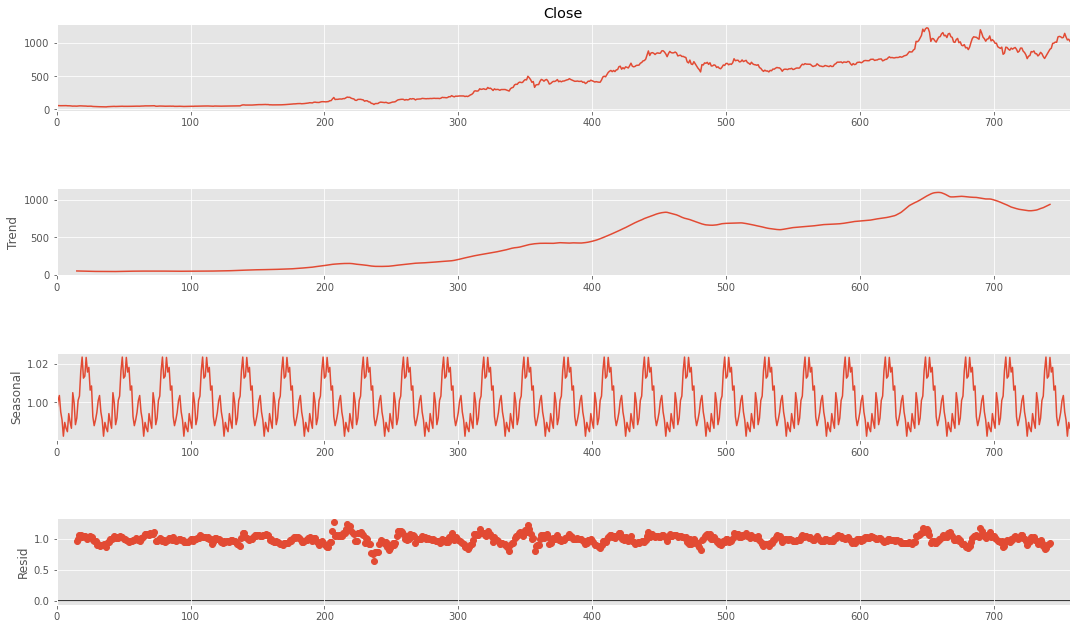

In [18]:
figure=decompose_TS_data.plot()
figure.set_size_inches(17,10)

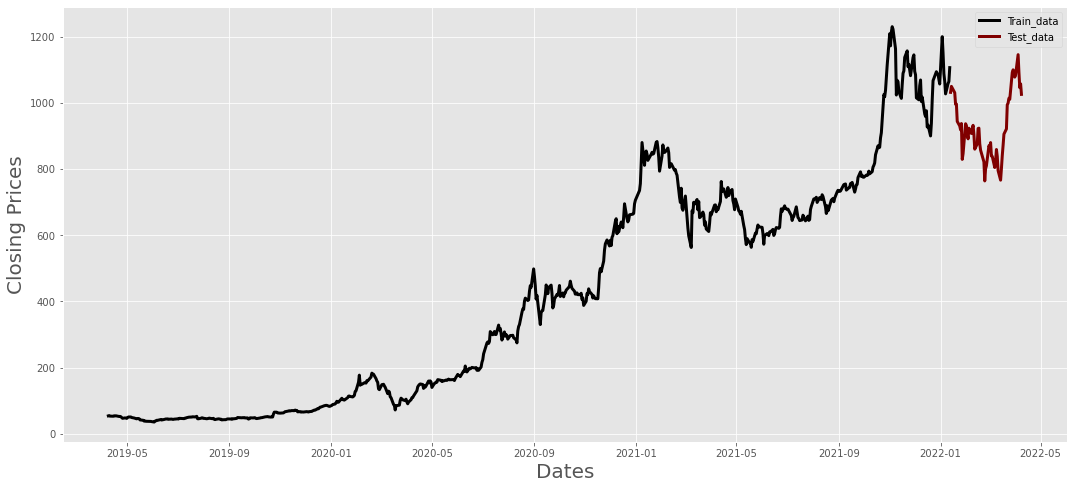

In [19]:
#split the data into train and test
train_data=data_close[:-60]
test_data=data_close[-60:]
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel("Dates",fontsize=20)
plt.ylabel("Closing Prices",fontsize=20)
plt.plot(train_data,"black",linewidth=3,label="Train_data")
plt.plot(test_data,"maroon",linewidth=3,label="Test_data")
plt.legend()

In [20]:
data_close.shape,train_data.shape,test_data.shape

((758,), (698,), (60,))

### Auto-correlations
After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

Autocorrelation function plot (ACF): Autocorrelation refers to how correlated a time series is with its past values whereas the ACF is the plot used to see the correlation between the points, up to and including the lag unit. In ACF, the correlation coefficient is in the x-axis whereas the number of lags is shown in the y-axis.
Normally, we employ either the AR term or the MA term in an ARIMA model. Both of these phrases are rarely used on rare occasions. The ACF plot is used to determine which of these terms we should utilise for our time series.

If the autocorrelation at lag 1 is positive, we utilise the AR model.
If the autocorrelation at lag 1 is negative, we employ the MA model.
We move on to Partial Autocorrelation function plots (PACF) after plotting the ACF plot.

Partial Autocorrelation function plots (PACF) A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
If the PACF plot drops off at lag n, then use an AR(n) model and if the drop in PACF is more gradual then we use the MA term.

Use AR terms in the model when the

ACF plots show autocorrelation decaying towards zero
PACF plot cuts off quickly towards zero
ACF of a stationary series shows positive at lag-1
Use MA terms in the model when the model is

Negatively Autocorrelated at Lag — 1
ACF that drops sharply after a few lags
PACF decreases more gradually

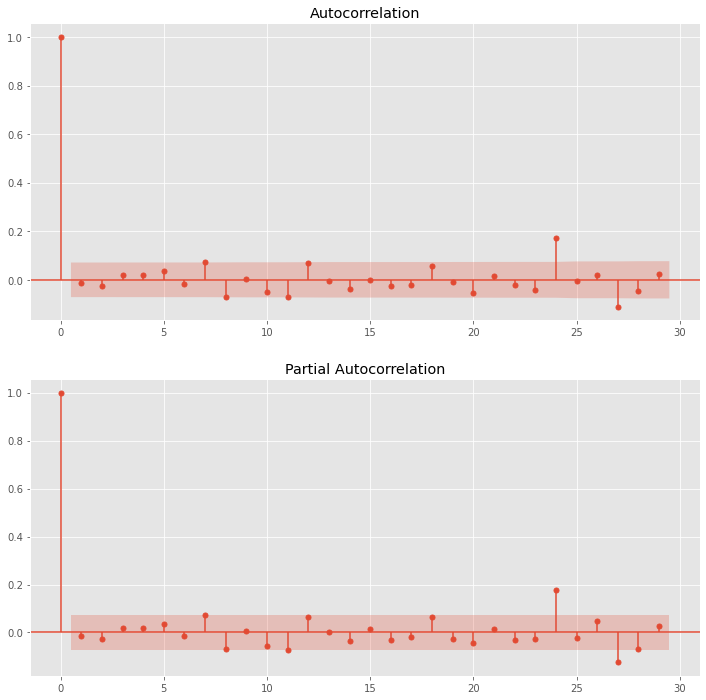

In [21]:
figure=plt.figure(figsize=(12,12))
axis1=figure.add_subplot(211)
figure=plot_acf(diff_data,ax=axis1)
axis2=figure.add_subplot(212)
figure=plot_pacf(diff_data,ax=axis2)

In [25]:
#Evaluating arima model 

def evaluate_arima_model(X,y,arima_order):
    history=[x for x in X]
    pred=[]
    for i in range(len(y)):
        model=ARIMA(history,order=arima_order)
        model_fit=model.fit()
        yhat=model_fir.forecast()[0]
        pred.append(yhat)
        history.append(y[i])
    rmse=np.sqrt(mean_squared_error(y,pred))
    return rmse

def evaluate_models(dataset,test,p,d,q):
    dataset=dataset.astype("float32")
    best_score,best_cfg=float("inf"),None
    for p_ in p:
        for d_ in d:
            for q_ in q:
                order=(p_,d_,q_)
                try:
                    rmse=evaluate_arima_model(dataset,test,order)
                    if rmse<best_score:
                        best_score,best_cfg=rmse,order
                    print("arima:{} \n rmse:{}".format(order,rmse))
                except:
                    continue
    print("best arima :{} \nrmse:{}".format(best_cfg,best_score))
# evaluate_params
p=range(0,3)
d=range(0,3)
q=range(0,3)
evaluate_models(train_data,test_data,p,d,q)

best arima :None 
rmse:inf


In [26]:
def evaluate_arima_model(X, y, arima_order):
    # prepare training dataset
    # make predictions list
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse
 
# evaluate different combinations of p, d and q values for an ARIMA model to get the best order for ARIMA Model
def evaluate_models(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_data, test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=502.651
ARIMA(0, 0, 1) RMSE=261.563
ARIMA(0, 1, 0) RMSE=38.028
ARIMA(0, 1, 1) RMSE=38.082
ARIMA(0, 1, 2) RMSE=38.136
ARIMA(0, 2, 0) RMSE=53.624
ARIMA(0, 2, 1) RMSE=38.187
ARIMA(0, 2, 2) RMSE=38.244
ARIMA(1, 0, 0) RMSE=37.920
ARIMA(1, 1, 0) RMSE=38.082
ARIMA(1, 1, 1) RMSE=38.106
ARIMA(1, 1, 2) RMSE=38.330
ARIMA(1, 2, 0) RMSE=48.273
ARIMA(1, 2, 1) RMSE=38.244
ARIMA(1, 2, 2) RMSE=38.188
ARIMA(2, 0, 0) RMSE=37.964
ARIMA(2, 1, 0) RMSE=38.133
ARIMA(2, 1, 1) RMSE=38.304
ARIMA(2, 2, 0) RMSE=45.430
ARIMA(2, 2, 1) RMSE=38.300
ARIMA(2, 2, 2) RMSE=38.264
Best ARIMA(1, 0, 0) RMSE=37.920


In [27]:
history=[x for x in train_data]
pred=[]
conf_list=[]
for i in range(len(test_data)):
    model=ARIMA(history,order=(1,0,0))
    model_fit=model.fit()
    forecast,se,conf=model_fit.forecast(alpha=0.05)
    pred.append(forecast)
    conf_list.append(conf)
    history.append(test_data[i])
print("rmse of arima model:",np.sqrt(mean_squared_error(test_data,pred)))

rmse of arima model: 37.93757977849265


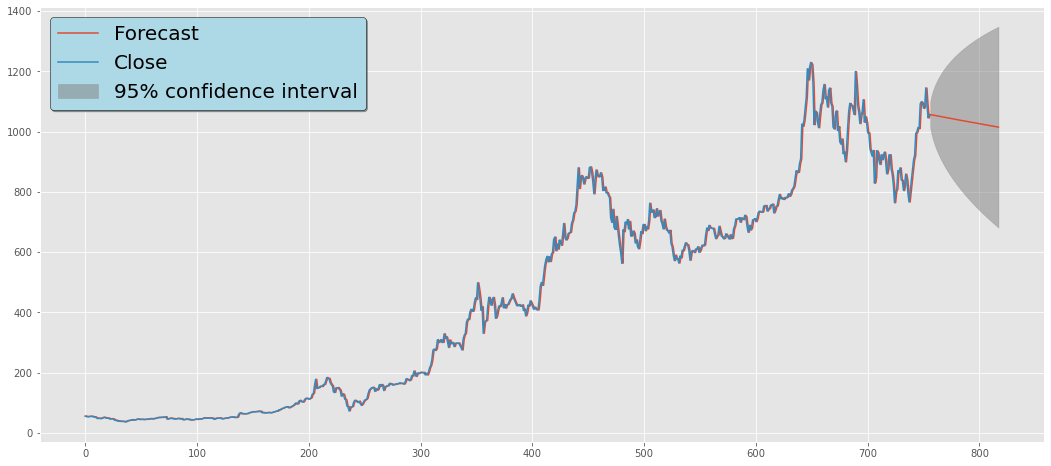

In [28]:
#forecasting future
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111)
model_fit.plot_predict(start=1, end=len(data_close)+60, ax = ax1)
plt.grid("both")
plt.legend(['Forecast','Close','95% confidence interval'],fontsize = 20, shadow=True,facecolor='lightblue',edgecolor = 'k')
plt.show()
